# 🏦 Bank Customer Churn Prediction
## Notebook 4 — Feature Engineering & Preprocessing

**Goal:** Transform the cleaned dataset into the numeric format required by scikit-learn models.  
Three major transformations:

1. **Standardise numerical features** — put all features on the same scale (mean=0, std=1).
2. **Encode categorical features** — convert text labels to numeric dummy variables.
3. **Balance the target variable** — apply SMOTE to fix the 80/20 class imbalance.

> **Why does order matter?**  
> We scale *before* encoding because scaling only applies to numerical columns. We balance *last*, after all feature transformations, to avoid creating synthetic rows from half-transformed data.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE

sns.set_theme(style='whitegrid')


# this df_cleaned.csv file is created in the N3_data_cleaning.ipynb notebook, so make sure to run that one before this one to have the cleaned data ready for loading here.
# this file is stored in the same folder as the original CSV, so if you run the N3 notebook, you should see it there. If you want to change the path or filename, just make sure to update it here as well.

df = pd.read_csv('df_cleaned.csv')
print(f'Cleaned data loaded: {df.shape}')
df.head()

Cleaned data loaded: (10000, 18)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


## 1. Separate Features (X) from Target (y)

In [3]:
X = df.drop('Exited', axis=1)   # Feature matrix — everything except the target
y = df['Exited']                 # Target vector — 0 or 1

print(f'X shape: {X.shape}  (features)')
print(f'y shape: {y.shape}  (target)')
print()
print('Feature columns:', X.columns.tolist())

X shape: (10000, 17)  (features)
y shape: (10000,)  (target)

Feature columns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Complain', 'Satisfaction Score', 'Card Type', 'Point Earned']


## 2. Why Standardise Numerical Features?

Many machine learning algorithms compute distances or gradients that are sensitive to the *scale* of features.
- Without scaling, `Balance` (range 0–250,000) would dominate `Tenure` (range 0–10).
- **StandardScaler** transforms each feature to have **mean = 0** and **std = 1**.

Formula: `z = (x - μ) / σ`  where μ is the column mean and σ is the column standard deviation.

**Important:** We use a `CustomScaler` that only scales *selected* columns. Binary features like `HasCrCard` and `IsActiveMember` already encode information as 0/1 — scaling them would distort this meaning.

```
Columns to scale  → CreditScore, Age, Tenure, Balance,
                    NumOfProducts, EstimatedSalary,
                    Satisfaction Score, Point Earned

Columns NOT scaled → HasCrCard, IsActiveMember  (binary 0/1 flags)
```

In [4]:
# ── CustomScaler definition ───────────────────────────────────────────────────
# We define the scaler here so it can be pickled and reused identically in the
# inference pipeline (BankChurn_Module.py). This guarantees that new data at
# prediction time is scaled with the SAME mean and std as training data.

class CustomScaler(BaseEstimator, TransformerMixin):
    """
    Applies StandardScaler only to specified columns.
    All other columns are returned unchanged.
    
    Inheriting from BaseEstimator and TransformerMixin gives us:
      - .get_params() / .set_params()  (sklearn compatibility)
      - .fit_transform()  (combines fit + transform in one call)
    """

    def __init__(self, columns, copy=True, with_mean=True, with_std=True):
        self.scaler    = StandardScaler(copy=copy, with_mean=with_mean, with_std=with_std)
        self.columns   = columns
        self.with_mean = with_mean
        self.with_std  = with_std
        self.copy      = copy
        self.mean_     = None
        self.std_      = None

    def fit(self, X, y=None):
        """Learn mean and std from training data."""
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.mean(X[self.columns])
        self.std_  = np.std(X[self.columns])
        return self

    def transform(self, X, y=None, copy=None):
        """Apply scaling, preserving original column order."""
        init_col_order = X.columns
        X_scaled    = pd.DataFrame(
            self.scaler.transform(X[self.columns]),
            columns=self.columns,
            index=X.index
        )
        X_notscaled = X.loc[:, ~X.columns.isin(self.columns)]
        return pd.concat([X_notscaled, X_scaled], axis=1)[init_col_order]

print('CustomScaler defined ✓')

CustomScaler defined ✓


In [5]:
# Select numerical columns to scale (explicitly listed — not by dtype)
# We exclude HasCrCard and IsActiveMember because they are binary flags
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',
                  'NumOfProducts', 'EstimatedSalary',
                  'Satisfaction Score', 'Point Earned']

# Instantiate and fit the scaler on the FULL dataset
# (No train/test split yet — we are building the preprocessing artifacts)
churn_scaler = CustomScaler(columns=numerical_cols)
churn_scaler.fit(X)

# Apply the transformation
X = churn_scaler.transform(X)

print('Scaling applied. Preview of scaled features:')
print(f'Balance mean (should ≈ 0): {X["Balance"].mean():.4f}')
print(f'Balance std  (should ≈ 1): {X["Balance"].std():.4f}')
X.head()

Scaling applied. Preview of scaled features:
Balance mean (should ≈ 0): -0.0000
Balance std  (should ≈ 1): 1.0001


c:\Users\Alfredo\Anaconda3\envs\dl_tex\lib\site-packages\numpy\_core\fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,-0.326221,France,Female,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,-0.721130,DIAMOND,-0.630839
1,2,15647311,Hill,-0.440036,Spain,Female,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,1,-0.009816,DIAMOND,-0.666251
2,3,15619304,Onio,-1.536794,France,Female,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,-0.009816,DIAMOND,-1.015942
3,4,15701354,Boni,0.501521,France,Female,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,1.412812,GOLD,-1.135457
4,5,15737888,Mitchell,2.063884,Spain,Female,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,1.412812,GOLD,-0.803472


In [ ]:
# ── Save the fitted scaler ─────────────────────────────────────────────────────
# Pickle serialises the Python object to disk so we can reload it during inference.
# CRITICAL: the inference pipeline must use transform() with THIS scaler object,
# not fit_transform(), or the scaling will differ from what the model was trained on.


with open('Scaler_file.pkl', 'wb') as f:
    pickle.dump(churn_scaler, f)

print('✅ Scaler saved to  Scaler_file.pkl')

✅ Scaler saved to  Scaler_file.pkl


## 3. One-Hot Encoding for Categorical Features

Machine learning models work with numbers, not text. We convert text categories to binary (0/1) columns using **one-hot encoding**.

**`drop_first=True`** removes the first category from each group to avoid the **dummy variable trap** (perfect multicollinearity):

| Feature | Categories | After encoding (drop_first) |
|---|---|---|
| Geography | France, Germany, Spain | `Geography_Germany`, `Geography_Spain` (France = 0,0) |
| Gender | Female, Male | `Gender_Male` (Female = 0) |
| Card Type | DIAMOND, GOLD, PLATINUM, SILVER | `Card Type_GOLD`, `_PLATINUM`, `_SILVER` (DIAMOND = 0,0,0) |

The dropped category becomes the **reference category** — all zeros in its group represent that category.

In [7]:
categorical_cols = ['Geography', 'Gender', 'Card Type']

print('Unique values before encoding:')
for col in categorical_cols:
    print(f'  {col}: {sorted(X[col].unique())}')

# pd.get_dummies() is pandas' one-hot encoder
# dtype='int' ensures we get integer 0/1 instead of boolean True/False
data_dummies = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype='int')

print(f'\nShape before encoding: {X.shape}')
print(f'Shape after  encoding: {data_dummies.shape}')
print('\nNew columns created:')
new_cols = [c for c in data_dummies.columns if c not in X.columns.tolist()]
print(new_cols)

Unique values before encoding:
  Geography: ['France', 'Germany', 'Spain']
  Gender: ['Female', 'Male']
  Card Type: ['DIAMOND', 'GOLD', 'PLATINUM', 'SILVER']

Shape before encoding: (10000, 17)
Shape after  encoding: (10000, 20)

New columns created:
['Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER']


In [8]:
# Re-attach the target variable and reorder columns consistently
# Consistent column order is critical — the saved model expects features in a fixed order
FEATURE_COLUMNS = [
    'HasCrCard', 'IsActiveMember', 'CreditScore', 'Age', 'Tenure',
    'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score',
    'Point Earned', 'Geography_Germany', 'Geography_Spain', 'Gender_Male',
    'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER'
]

data_processed = pd.concat([data_dummies[FEATURE_COLUMNS], y], axis=1)

print('Final processed data shape:', data_processed.shape)
print('Columns:', data_processed.columns.tolist())
data_processed.head()

Final processed data shape: (10000, 17)
Columns: ['HasCrCard', 'IsActiveMember', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score', 'Point Earned', 'Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER', 'Exited']


,HasCrCard,IsActiveMember,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Exited
0,1,1,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.021886,-0.721130,-0.630839,0,0,0,0,0,0,1
1,0,1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0.216534,-0.009816,-0.666251,0,1,0,0,0,0,0
2,1,0,-1.536794,0.293517,1.032908,1.333053,2.527057,0.240687,-0.009816,-1.015942,0,0,0,0,0,0,1
3,0,0,0.501521,0.007457,-1.387538,-1.225848,0.807737,-0.108918,1.412812,-1.135457,0,0,0,1,0,0,0
4,1,1,2.063884,0.388871,-1.041760,0.785728,-0.911583,-0.365276,1.412812,-0.803472,0,1,0,1,0,0,0


## 4. Handling Class Imbalance with SMOTE

Our target variable has **~80% class 0 (stayed) and ~20% class 1 (churned)**.  
Without correction, a classifier can achieve 80% accuracy by *always predicting 0* — useless for identifying churners.

**SMOTE (Synthetic Minority Over-sampling Technique):**
- Creates *synthetic* new minority class samples by interpolating between existing minority samples.
- Unlike random oversampling (just duplicating rows), SMOTE adds *new, diverse* examples.
- Result: a perfectly balanced dataset (50/50 split).

**Important:** SMOTE must be applied **only on training data** in a production pipeline. Here we apply it to the full dataset because we are building a final production model (not evaluating generalisation — that was done in N5).

In [9]:
X_features = data_processed.drop('Exited', axis=1)
y_target   = data_processed['Exited']

print('Before SMOTE:')
print(y_target.value_counts())
print(f'Class balance: {y_target.mean()*100:.1f}% churned')

# Apply SMOTE — random_state for reproducibility
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_features, y_target)

print('\nAfter SMOTE:')
print(y_resampled.value_counts())
print(f'Class balance: {y_resampled.mean()*100:.1f}% churned')

Before SMOTE:
Exited
0    7962
1    2038
Name: count, dtype: int64
Class balance: 20.4% churned


c:\Users\Alfredo\Anaconda3\envs\dl_tex\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



After SMOTE:
Exited
1    7962
0    7962
Name: count, dtype: int64
Class balance: 50.0% churned


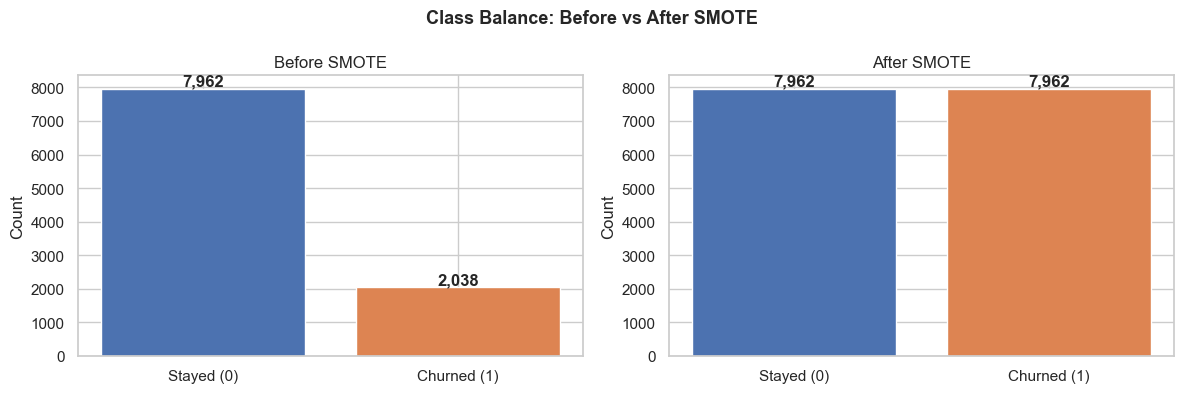

In [10]:
# Visualise the before/after balance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, counts, title in zip(
    axes,
    [y_target.value_counts(), y_resampled.value_counts()],
    ['Before SMOTE', 'After SMOTE']
):
    ax.bar(['Stayed (0)', 'Churned (1)'], counts.values,
           color=['#4C72B0', '#DD8452'], edgecolor='white')
    for i, v in enumerate(counts.values):
        ax.text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('Count')

plt.suptitle('Class Balance: Before vs After SMOTE', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
# Combine and save the fully processed dataset
data_smoted = pd.concat(
    [pd.DataFrame(X_resampled, columns=FEATURE_COLUMNS),
     y_resampled.reset_index(drop=True)],
    axis=1
)

data_smoted.to_csv('data_processed.csv', index=False)

print(f'✅ Processed data saved to  data_processed.csv')
print(f'   Final shape: {data_smoted.shape}')

✅ Processed data saved to  data_processed.csv
   Final shape: (15924, 17)


---
## ✅ Feature Engineering Summary

| Step | Input | Output |
|---|---|---|
| Separate X / y | 14 cols | 13 features + 1 target |
| Standardise numerical (8 cols) | Raw values | mean=0, std=1 |
| One-hot encode (3 cols) | Geography, Gender, Card Type | +6 binary columns |
| Reorder & finalize | Mixed order | 16 features in fixed order |
| SMOTE oversampling | 8,000 / 2,000 imbalance | 8,000 / 8,000 balanced |
| **Final dataset** | — | **16,000 rows × 17 cols** |

**Artifacts saved:**
- `Scaler_file.pkl` — fitted CustomScaler for inference pipeline.
- `data_processed.csv` — SMOTE-balanced, fully encoded training data.

➡️ Continue to **N5_Model_Train_Test_Selection**.